# AM data analysis

#### Description of data and aims:
In the summer of 2024, a mysterious disease dubbed the “pundemic” by the media began cropping up worldwide. Diseased patients make puns at every opportunity. A link between the pundemic and changes in the gut microbiome was discovered, and a doctor at the USZ set up a clinical trial using fecal microbiota transplants (FMT) as a possible treatment.

Trial data:  
Collection of fecal microbiome samples from pundemic patients before and after the trial, from both treatment and placebo groups. Pundemic severity in patients was quantified in terms of puns per hour. Fecal samples were collected from the FMT donors as well.

Because the bacterial and fungal gut microbiome are both of interest, the USZ team collected both **16S rRNA gene** and **ITS** data from the study cohort. 

Aims:
1. Analyzing the ITS data in order to further explore the connection between pundemic symptoms and an altered gut mycobiome composition
2. Analyzing the potential of FMT as a pandemic treatment option. You have received DNA sequences as well as metadata allowing you to distinguish pundemic from healthy samples.


In [33]:
# Package import
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt
import numpy as np
import qiime2 as q2
import seaborn as sns

%matplotlib inline

In [34]:
data_dir = 'data'

## Data import and denoising

In [3]:
# Data and metadata import
#! wget -O data/raw/pundemic_metadata.tsv https://polybox.ethz.ch/index.php/s/7LxWSbaw2q37yof/download
#! wget -O data/raw/pundemic_forward_reads.qza https://polybox.ethz.ch/index.php/s/o8HqHJqvuf9e2on/download


In [16]:
# Metadata df creation and overview
meta_df = pd.read_csv(f'{data_dir}/pundemic_metadata.tsv', sep='\t', index_col=0)
meta_df

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR10505151,D54,Unknown,Unknown,NaN,Europe,Switzerland,Zurich,Zurich,Healthy,donor,NaN,NaN,NaN,t1
SRR10505152,D53,Unknown,Unknown,NaN,Europe,Switzerland,Zurich,Zurich,Healthy,donor,NaN,NaN,NaN,t1
SRR10505153,2225,34,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,NR,6.0,5.0,pre-treatment


In [17]:
meta_df.head()

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment


In [18]:
meta_df['disease_subgroup'].unique()

array(['Placebo', 'FMT', 'donor'], dtype=object)

In [20]:
patient_df = meta_df[(meta_df['disease_subgroup'] == "placebo") | (meta_df['disease_subgroup'] == "FMT")]
patient_df.to_csv(f'{data_dir}/patient_df', sep = '\t')

In [21]:
donor_df = meta_df[(meta_df['disease_subgroup'] == "donor")]
donor_df.to_csv(f'{data_dir}/donor_df', sep = '\t')

In [22]:
meta_df[(meta_df['time_point'] == "pre-treatment") | (meta_df['time_point'] == "post-treatment")]

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR10505141,1001,57,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,Res,7.0,2.0,pre-treatment
SRR10505142,1001,57,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,Res,7.0,2.0,post-treatment
SRR10505153,2225,34,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,NR,6.0,5.0,pre-treatment


We have 105 samples

### Some Plots exploring data

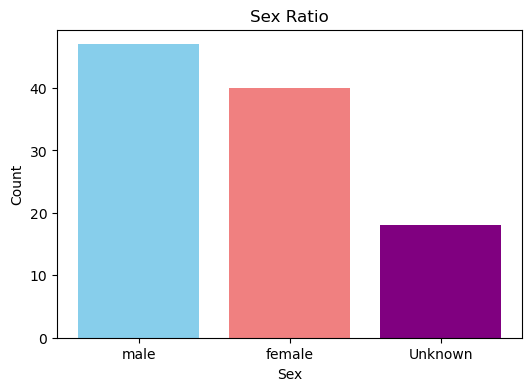

In [23]:
sex_counts = meta_df['sex'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(sex_counts.index, sex_counts.values, color=['skyblue', 'lightcoral', 'purple'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Ratio')
plt.show()

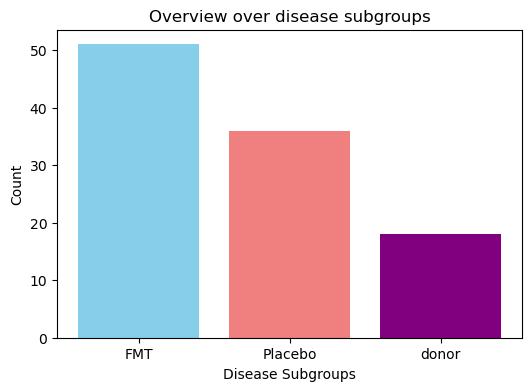

In [11]:
disease_counts = meta_df['disease_subgroup'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(disease_counts.index, disease_counts.values, color=['skyblue', 'lightcoral', 'purple'])
plt.xlabel('Disease Subgroups')
plt.ylabel('Count')
plt.title('Overview over disease subgroups')
plt.show()

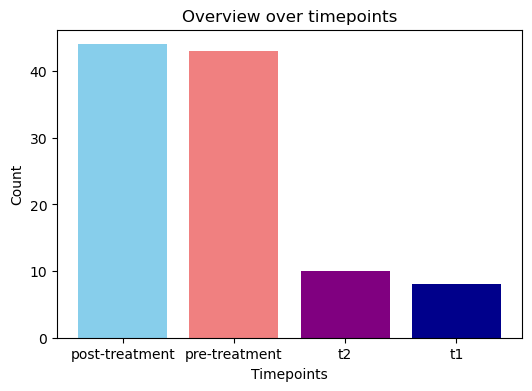

In [12]:
time_counts = meta_df['time_point'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(time_counts.index, time_counts.values, color=['skyblue', 'lightcoral', 'purple', 'darkblue'])
plt.xlabel('Timepoints')
plt.ylabel('Count')
plt.title('Overview over timepoints')
plt.show()

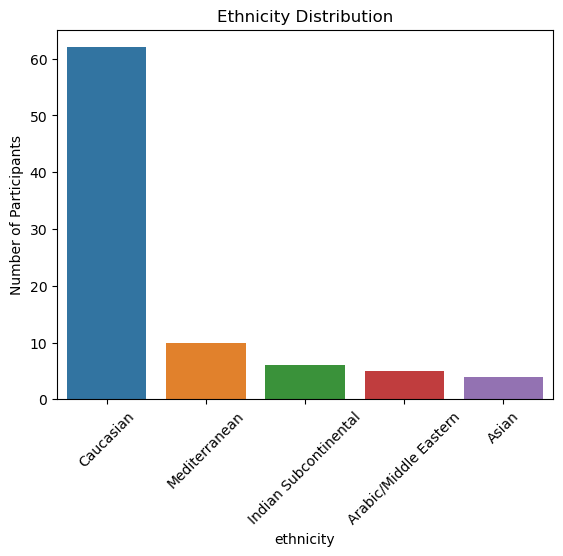

In [40]:
#ethnicity distribution
sns.countplot(data = meta_df, x='ethnicity', order=meta_df['ethnicity'].value_counts().index)
plt.title("Ethnicity Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Participants")
plt.show()

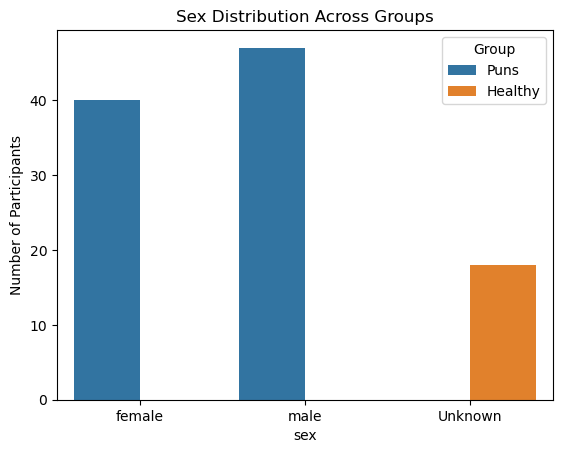

In [43]:
#Sex Distribution Across Groups
sns.countplot(data=meta_df, x='sex', hue='group')
plt.title("Sex Distribution Across Groups")
plt.ylabel("Number of Participants")
plt.legend(title="Group")
plt.show()

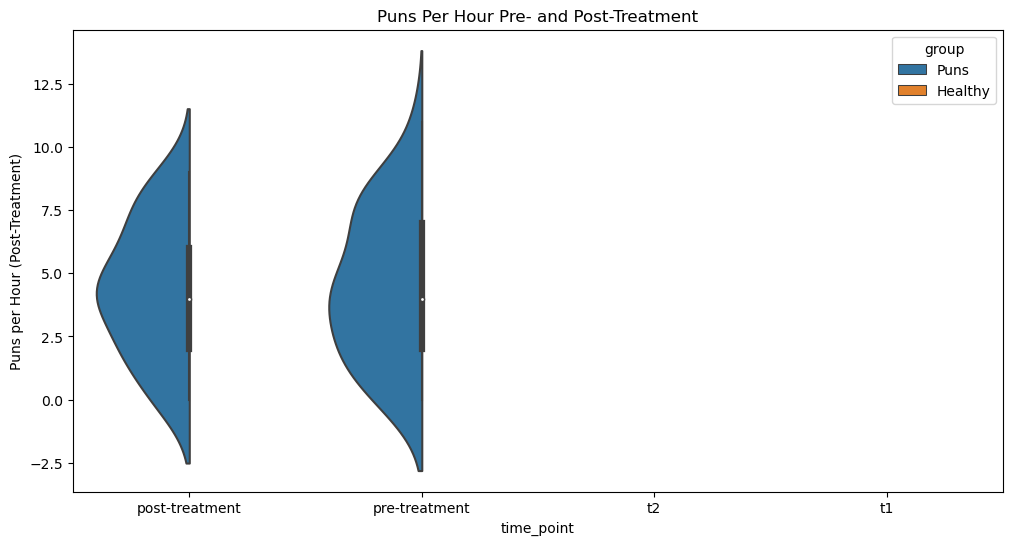

In [45]:
#Puns per Hour Pre- and Post-Treatment
plt.figure(figsize=(12, 6))
sns.violinplot(data = meta_df, x = 'time_point', y = 'puns_per_hour_post_treatment', hue='group', split=True)
plt.title("Puns Per Hour Pre- and Post-Treatment")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

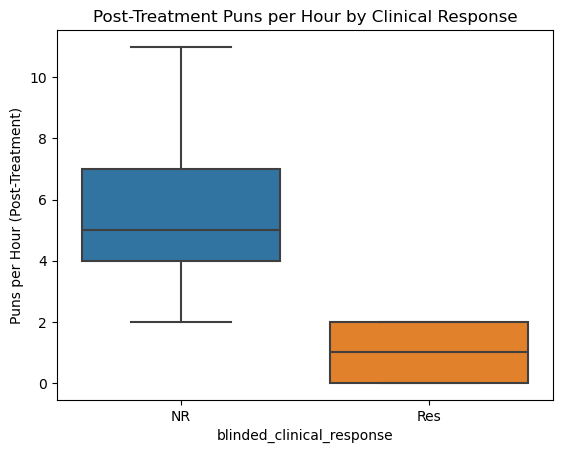

In [47]:
#Blinded Clinical Response Analysis
sns.boxplot(data=meta_df, x='blinded_clinical_response', y='puns_per_hour_post_treatment')
plt.title("Post-Treatment Puns per Hour by Clinical Response")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

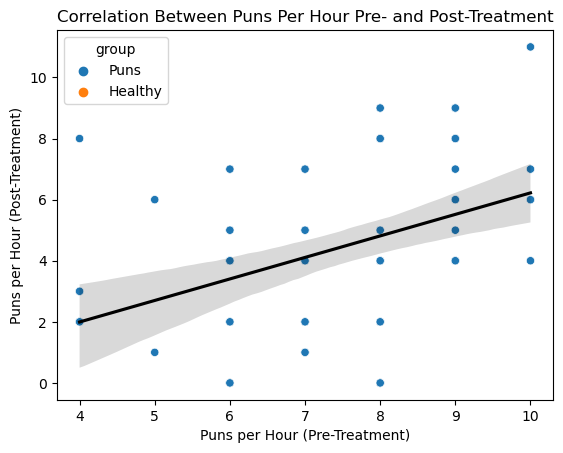

In [48]:
#Correlation Between Puns per Hour Pre- and Post-Treatment
sns.scatterplot(data=meta_df, x='puns_per_hour_pre_treatment', y='puns_per_hour_post_treatment', hue='group')
sns.regplot(data=meta_df, x='puns_per_hour_pre_treatment', y='puns_per_hour_post_treatment', scatter=False, color='black')
plt.title("Correlation Between Puns Per Hour Pre- and Post-Treatment")
plt.xlabel("Puns per Hour (Pre-Treatment)")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

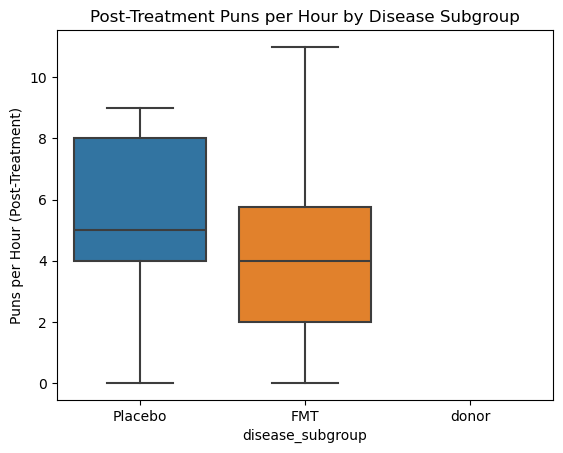

In [50]:
#Puns per Hour Across Disease Subgroups
sns.boxplot(data=meta_df, x='disease_subgroup', y='puns_per_hour_post_treatment')
plt.title("Post-Treatment Puns per Hour by Disease Subgroup")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

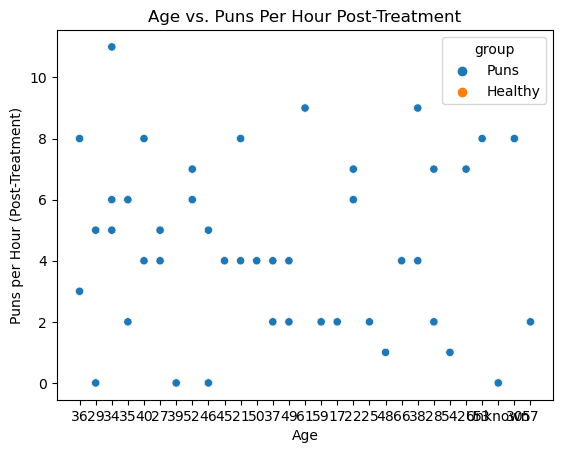

In [52]:
#Age vs. Puns per Hour Post-Treatment
sns.scatterplot(data=meta_df, x='age', y='puns_per_hour_post_treatment', hue='group')
plt.title("Age vs. Puns Per Hour Post-Treatment")
plt.xlabel("Age")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

## Sequence Import

In [13]:
! qiime tools peek $data_dir/pundemic_forward_reads.qza

Traceback (most recent call last):
  File "/opt/conda/bin/qiime", line 11, in <module>
    sys.exit(qiime())
  File "/opt/conda/lib/python3.9/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/opt/conda/lib/python3.9/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/opt/conda/lib/python3.9/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/opt/conda/lib/python3.9/site-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/opt/conda/lib/python3.9/site-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/q2cli/builtin/tools.py", line 272, in peek
    metadatas = {os.path

In [27]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads.qza \
    --o-visualization $data_dir/pundemic_forward_reads.qzv

Saved Visualization to: data/pundemic_forward_reads.qzv


In [28]:
Visualization.load(f"{data_dir}/pundemic_forward_reads.qzv")

<visualization: Visualization uuid: e30a37c7-88fe-47ac-9552-d6eba5bf58ab>

## Check for primer sequences in data

In [51]:
! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/pundemic_forward_reads.qza \
  --p-front CTTGGTCATTTAGAGGAAGTAA \
  --p-front TCGTCGGCAGCGTCAGATGTGTATAAGAGACAG \
  --p-error-rate 0 \
  --verbose \
  --o-trimmed-sequences $data_dir/pundemic_forward_reads_trimmed.qza | tee $data_dir/cutadaptresults.log \

This is cutadapt 4.9 with Python 3.9.19
Command line parameters: --cores 1 --error-rate 0 --times 1 --overlap 3 --minimum-length 1 -q 0,0 --quality-base 33 -o /tmp/q2-CasavaOneEightSingleLanePerSampleDirFmt-wzg7r1y1/SRR10505051_00_L001_R1_001.fastq.gz --front CTTGGTCATTTAGAGGAAGTAA --front TCGTCGGCAGCGTCAGATGTGTATAAGAGACAG /tmp/qiime2/jovyan/data/15b104e4-bd22-4469-92ac-e08f76767733/data/SRR10505051_00_L001_R1_001.fastq.gz
Processing single-end reads on 1 core ...
Done           00:00:00        37,345 reads @  16.0 µs/read;   3.75 M reads/minute
Finished in 0.601 s (16.080 µs/read; 3.73 M reads/minute).

=== Summary ===

Total reads processed:                  37,345
Reads with adapters:                    21,422 (57.4%)

== Read fate breakdown ==
Reads that were too short:                   0 (0.0%)
Reads written (passing filters):        37,345 (100.0%)

Total basepairs processed:     9,336,250 bp
Quality-trimmed:                       0 bp (0.0%)
Total written (filtered):      8,865

In [52]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads_trimmed.qza \
    --o-visualization $data_dir/pundemic_forward_reads_trimmed.qzv

Saved Visualization to: data/pundemic_forward_reads_trimmed.qzv


In [53]:
Visualization.load(f"{data_dir}/pundemic_forward_reads_trimmed.qzv")

<visualization: Visualization uuid: f211c343-3679-49ab-9ee6-a1735c8ef573>

In [26]:
! qiime dada2 denoise-single --help

Usage: qiime dada2 denoise-single [OPTIONS]

  This method denoises single-end sequences, dereplicates them, and filters
  chimeras.

Inputs:
  --i-demultiplexed-seqs ARTIFACT SampleData[SequencesWithQuality |
    PairedEndSequencesWithQuality]
                          The single-end demultiplexed sequences to be
                          denoised.                                 [required]
Parameters:
  --p-trunc-len INTEGER   Position at which sequences should be truncated due
                          to decrease in quality. This truncates the 3' end of
                          the of the input sequences, which will be the bases
                          that were sequenced in the last cycles. Reads that
                          are shorter than this value will be discarded. If 0
                          is provided, no truncation or length filtering will
                          be performed                              [required]
  --p-trim-left INTEGER   Position at which se

## Denoising
Our sequences originate from the ITS-1 region and were sequenced on an Illumina MiSeq machine. The sequence files contain demultiplexed single-end sequences.

We're not trimming the data (p-trun-len = 0).

Previous approach: For denoising we are trimming the data after 129 nucleotides (at 130 first time 25 per centile quality score dropped below 20). We're doing this using DADA2. It also removes chimeras. The output of applying DADA gives us features which are representative sequences for organisms.

In [54]:
! qiime dada2 denoise-single \
    --i-demultiplexed-seqs $data_dir/pundemic_forward_reads_trimmed.qza \
    --p-trunc-len 0 \
    --p-n-threads 3 \
    --o-table $data_dir/dada/dada2_table.qza \
    --o-representative-sequences $data_dir/dada/dada2_rep_seq.qza \
    --o-denoising-stats $data_dir/dada/dada2_stats.qza

Saved FeatureTable[Frequency] to: data/dada2_table.qza
Saved FeatureData[Sequence] to: data/dada2_rep_seq.qza
Saved SampleData[DADA2Stats] to: data/dada2_stats.qza


In [57]:
! qiime metadata tabulate \
    --m-input-file $data_dir/dada/dada2_stats.qza \
    --o-visualization $data_dir/dada/dada2_stats.qzv

Saved Visualization to: data/dada/dada2_stats.qzv


In [58]:
Visualization.load(f"{data_dir}/dada/dada2_stats.qzv")

<visualization: Visualization uuid: 3add4977-8832-4e55-a125-87bf9413aebb>

In [44]:
! qiime feature-table tabulate-seqs \
    --i-data $data_dir/dada/dada2_rep_seq.qza \
    --o-visualization $data_dir/dada/dada2_rep_seq.qzv

Saved Visualization to: data/dada2_rep_seq.qzv


In [45]:
Visualization.load(f"{data_dir}/dada/dada2_rep_seq.qzv")

<visualization: Visualization uuid: 62317d6c-934d-41a8-b98a-48299bd7d866>

We can also visualize the feature table. We will include the metadata file to enrich the table with information on sample groups.

In [46]:
! qiime feature-table summarize \
    --i-table $data_dir/dada/dada2_table.qza \
    --m-sample-metadata-file $data_dir/dada/pundemic_metadata.tsv \
    --o-visualization $data_dir/dada/dada2_table.qzv

Saved Visualization to: data/dada2_table.qzv


In [47]:
Visualization.load(f"{data_dir}/dada/dada2_table.qzv")

<visualization: Visualization uuid: cfc6d9cd-a0d0-407a-8f3b-05b809481bce>